# HW2

подключение всего

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [2]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

## Анализ train

Посмотрим что у нас в train

In [3]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


Посмотрим различие в категориальных данных для сего действия строим диаграммы

In [4]:
train.gender.value_counts(normalize=True)

Female    0.589180
Male      0.410486
Other     0.000333
Name: gender, dtype: float64

Видим, что есть три пола, хоть и "Other" почти отсутствует, "Male" меньше, чем "Female", но в мире наоборот мужской части населения больше, чем женской.

In [5]:
train.hypertension.value_counts(normalize=True)

0    0.90547
1    0.09453
Name: hypertension, dtype: float64

Из этой серии мы можем сделать вывод, что гипертонией страдают около 9.5%, а в мире 16-30%

In [6]:
train.heart_disease.value_counts(normalize=True)

0    0.952168
1    0.047832
Name: heart_disease, dtype: float64

Здесь видно что около 5% страдают от сердечной не достаточности

In [7]:
train.ever_married.value_counts(normalize=True)

Yes    0.645845
No     0.354155
Name: ever_married, dtype: float64

Тут мы видем что 2/3 опрошенных были женаты

In [8]:
train.work_type.value_counts(normalize=True)

Private          0.573981
Self-employed    0.155795
children         0.139595
Govt_job         0.126796
Never_worked     0.003833
Name: work_type, dtype: float64

Видно, что не работающих всего 0,3% от выборки, при этом около 57% решили не говорить где работают

In [9]:
train.Residence_type.value_counts(normalize=True)

Urban    0.500917
Rural    0.499083
Name: Residence_type, dtype: float64

Видно, что поделены почти поровну

In [10]:
train['smoking_status'] = train['smoking_status'].fillna('no data')
test['smoking_status'] = test['smoking_status'].fillna('no data')
train.smoking_status.value_counts(normalize=True)

never smoked       0.369288
no data            0.305856
formerly smoked    0.172761
smokes             0.152095
Name: smoking_status, dtype: float64

Тут мы видим что у нас много отсутствующей информации(около 30,5%)

А теперь посмотрим распределение числовых данных, для начала добавим среднее значение bmi к Nan.

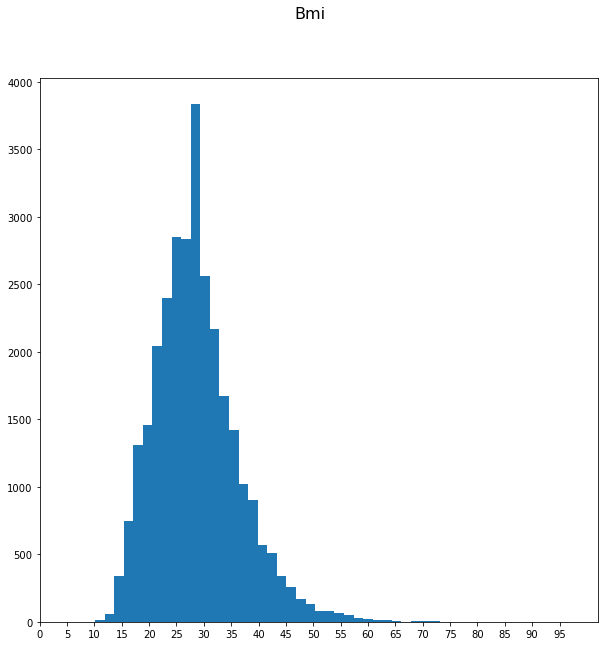

In [11]:
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Bmi', fontsize=16)
plt.hist(train.bmi.values,bins=50)
plt.xticks(range(0, 100, 5))
plt.show()

ИМТ лежит в основном между 20 и 30

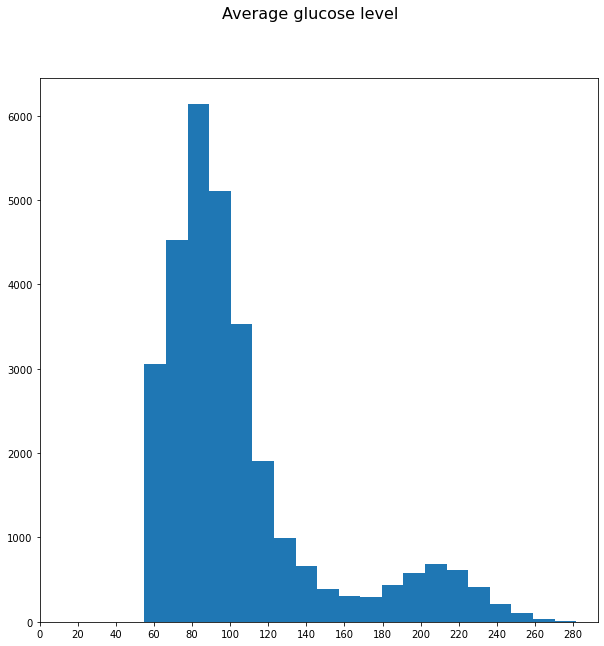

In [12]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Average glucose level', fontsize=16)
plt.hist(train.avg_glucose_level.values,bins=20) 
plt.xticks(range(0, 300, 20))
plt.show()

Хоть мы и не знаем единицы измерения глюкозы в крови, но обычно это мг/л, и по данным из вики норма это 72-99, если больше то у человека диабет, видим, что у большенства в норме, но есть и диабетники

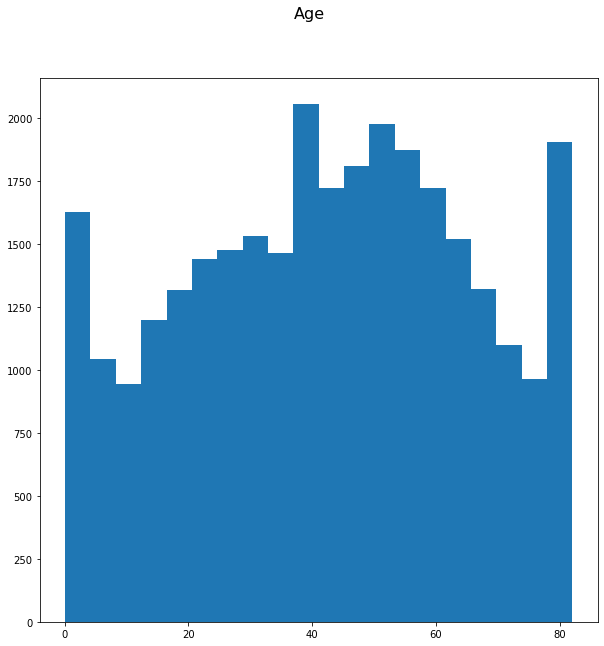

In [13]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Age', fontsize=16)
plt.hist(train.age.values,bins=20) 
plt.show()

Из этой диаграммы мы видем что данные у нас о людях разных возрастов

## Feature generation

Для начала добавим средний ИМТ в тестовый датасет

In [14]:
test['bmi'] = test['bmi'].fillna(mean_bmi) # замещение Nan

Ну и заменим все да/нет на 1/0

In [15]:
ever_married_dict = {'Yes': 1, 'No':0 }
train['ever_married'] =train['ever_married'].replace(ever_married_dict)
test['ever_married'] = test['ever_married'].replace(ever_married_dict)

Проделаем нечто похожее с данными про работу, где 1-i это если мы знаем что то и 0 если нет

In [16]:
for i in train['work_type'].unique():
    train['work_type_is_{}'.format(i)] = (train['work_type'] == i)*1
    test['work_type_is_{}'.format(i)] = (test['work_type'] == i)*1

Тут замения знания о курильщиках на средние значения количества инсультов на тип курильщика

In [17]:
smoking_status_target_enc_dict = (train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()['mean']
train['smoking_status_target_enc'] = train['smoking_status'].replace(smoking_status_target_enc_dict)
test['smoking_status_target_enc'] = test['smoking_status'].replace(smoking_status_target_enc_dict)
for i in train['smoking_status'].unique():
    train['smoking_status_is_{}'.format(i)] = (train['smoking_status'] == i)*1
    test['smoking_status_is_{}'.format(i)] = (test['smoking_status'] == i)*1

Так же оцифруем знание место проживания

In [18]:
residence_target_enc_dict = (train.groupby(['Residence_type'])['stroke'].agg(['mean'])).to_dict()['mean']
train['residence_target_enc'] = train['Residence_type'].replace(residence_target_enc_dict)
test['residence_target_enc'] = test['Residence_type'].replace(residence_target_enc_dict)
train['Residence_type'] = train['Residence_type'].replace({'Urban':0, 'Rural':1 })
test['Residence_type'] = test['Residence_type'].replace({'Urban':0, 'Rural':1 })

А теперь получим средние количество инсультов на половую принадлежность и добавим категориальные столбцы

In [19]:
gender_target_enc_dict = (train.groupby(['gender'])['stroke'].agg(['mean'])).to_dict()['mean']
train['gender_target_enc'] = train['gender'].replace(gender_target_enc_dict)
test['gender_target_enc'] = test['gender'].replace(gender_target_enc_dict)
for i in train['gender'].unique():
    train['gender_is_{}'.format(i)] = (train['gender'] == i)*1
    test['gender_is_{}'.format(i)] = (test['gender'] == i)*1

Посмотрим на корреляционную таблицу еще раз

In [20]:
cor = train.corr()
cor.style.background_gradient(cmap='coolwarm')

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes,residence_target_enc,gender_target_enc,gender_is_Male,gender_is_Female,gender_is_Other
id,1.000000,0.013442,0.009823,0.006829,0.010390,-0.002929,0.022125,0.017264,0.007366,-0.023171,0.010468,0.003001,0.008908,-0.001690,0.016353,-0.018663,0.007300,0.009015,0.004645,0.002929,-0.002288,-0.002129,0.002093,0.000982
age,0.013442,1.000000,0.274369,0.252770,0.689001,-0.003792,0.234806,0.349115,0.152684,-0.638318,0.139042,-0.067300,0.323558,0.118051,0.371383,-0.374952,0.106128,0.242490,0.083195,0.003792,-0.026886,-0.028615,0.028762,-0.004046
hypertension,0.009823,0.274369,1.000000,0.121906,0.177805,0.003555,0.161272,0.153921,0.073425,-0.129489,-0.002030,-0.018199,0.108435,0.023080,0.117109,-0.118540,0.033924,0.076262,0.026224,-0.003555,0.024683,0.024055,-0.023833,-0.005900
heart_disease,0.006829,0.252770,0.121906,1.000000,0.126129,0.003691,0.149709,0.057083,0.101548,-0.089377,-0.005263,-0.013903,0.102257,-0.007957,0.094484,-0.059288,-0.034605,0.082667,0.035553,-0.003691,0.078919,0.080314,-0.080152,-0.004093
ever_married,0.010390,0.689001,0.177805,0.126129,1.000000,-0.003797,0.151777,0.339788,0.069678,-0.543941,0.155254,-0.078130,0.193200,0.139750,0.297520,-0.322222,0.094978,0.170825,0.105967,0.003797,-0.031032,-0.033236,0.033438,-0.005568
Residence_type,-0.002929,-0.003792,0.003555,0.003691,-0.003797,1.000000,0.004940,0.002683,-0.002790,0.003816,-0.002860,-0.004741,0.002258,-0.001305,-0.000043,0.006136,-0.003087,0.006393,-0.010455,-1.000000,-0.001116,-0.000300,0.000163,0.003686
avg_glucose_level,0.022125,0.234806,0.161272,0.149709,0.151777,0.004940,1.000000,0.181794,0.087426,-0.111774,0.009976,-0.014092,0.079624,0.017426,0.104047,-0.094419,0.012353,0.074407,0.026217,-0.004940,0.034690,0.034044,-0.033771,-0.007260
bmi,0.017264,0.349115,0.153921,0.057083,0.339788,0.002683,0.181794,1.000000,0.018494,-0.450905,0.191899,-0.018987,0.084499,0.095882,0.230895,-0.271248,0.108983,0.119922,0.075326,-0.002683,-0.022472,-0.022851,0.022802,0.001249
stroke,0.007366,0.152684,0.073425,0.101548,0.069678,-0.002790,0.087426,0.018494,1.000000,-0.052556,0.003986,-0.008319,0.047045,-0.000914,0.041743,-0.031358,-0.002476,0.035096,0.006616,0.002790,0.010261,0.010000,-0.009908,-0.002449
work_type_is_children,-0.023171,-0.638318,-0.129489,-0.089377,-0.543941,0.003816,-0.111774,-0.450905,-0.052556,1.000000,-0.467539,-0.024986,-0.173036,-0.153489,-0.398120,0.515380,-0.236071,-0.166010,-0.169256,-0.003816,0.089502,0.091674,-0.091585,-0.002086


Из этой матрицы корреляции можно видеть, что существует прямая корреляция между Residence_target_enc и типом места жительства, что очевидно, поскольку один признак является производным от другого. Также существует сильная корреляция и статуса брака, и курения. Кроме того, ясно видно, что если функция получена из другого (например, Smoking_status_is ... и Smoking_status_enc_dict), корреляция наблюдается.

Давайте посмотрим на финальную таблицу

In [36]:
pd.options.display.max_columns = 200
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes,residence_target_enc,gender_target_enc,gender_is_Male,gender_is_Female,gender_is_Other
0,30669,1,3.0,0,0,0,4,1,95.12,18.0,2,0,1,0,0,0,0,0.011443,1,0,0,0,0.017298,0.019245,1,0,0
1,30468,1,58.0,1,0,1,2,0,87.96,39.2,1,0,0,1,0,0,0,0.017240,0,1,0,0,0.018033,0.019245,1,0,0
2,16523,0,8.0,0,0,0,2,0,110.89,17.6,2,0,0,1,0,0,0,0.011443,1,0,0,0,0.018033,0.016576,0,1,0
3,56543,0,70.0,0,0,1,2,1,69.04,35.9,0,0,0,1,0,0,0,0.027783,0,0,1,0,0.017298,0.016576,0,1,0
4,46136,1,14.0,0,0,0,1,1,161.28,19.1,2,0,0,0,1,0,0,0.011443,1,0,0,0,0.017298,0.019245,1,0,0


Переведем оставшиеся категориальные признаки в цифры

In [29]:
encod = LabelEncoder()
encod.fit(train['gender'])

train['gender'], test['gender'] = encod.transform(train['gender']), encod.transform(test['gender'])

In [30]:
encod = LabelEncoder()
encod.fit(train['work_type'])

train['work_type'], test['work_type'] = encod.transform(train['work_type']), encod.transform(test['work_type'])

In [34]:
encod = LabelEncoder()
encod.fit(train['smoking_status'])

train['smoking_status'], test['smoking_status'] = encod.transform(train['smoking_status']), encod.transform(test['smoking_status'])

In [38]:
train.smoking_status.value_counts(normalize=True)

1    0.369288
2    0.305856
0    0.172761
3    0.152095
Name: smoking_status, dtype: float64

## Выбор оптимальных гиперпарметров для модели


Для начала поделим тренировочные данные 80:20 для того чтоб были тестовые данные

In [41]:
res = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(train, res, test_size=0.2)

Теперь напишем кросс-валидационную функцию, которая возвращает коэф ROC-AUC

In [23]:
def my_cross_validation_for_roc_auc(clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
    return scores

In [39]:
features = X_train.columns

### Logistic regression

Воспользуемся логистической регрессией

In [25]:
model = linear_model.LogisticRegression()

In [42]:
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

id 0.509723815077583
gender 0.4841700179914222
age 0.8377788829479218
hypertension 0.5804477425450758
heart_disease 0.5818719466093258
ever_married 0.6274767720326944
work_type 0.5161163952546737
Residence_type 0.5048240908497335
avg_glucose_level 0.6097158573027274
bmi 0.5716550614510453
smoking_status 0.554365012037469
stroke 1.0
work_type_is_children 0.5689294265889268
work_type_is_Private 0.5073642000372951
work_type_is_Never_worked 0.5018445685160136
work_type_is_Self-employed 0.5684988708755137
work_type_is_Govt_job 0.4945724445269059
smoking_status_target_enc 0.5838932498024522
smoking_status_is_no data 0.5540697848532685
smoking_status_is_never smoked 0.4949557796361629
smoking_status_is_formerly smoked 0.5509201038279701
smoking_status_is_smokes 0.508542386249902
residence_target_enc 0.5048240908497335
gender_target_enc 0.4842973525978918
gender_is_Male 0.4842515813115399
gender_is_Female 0.48418791400830496
gender_is_Other 0.5001908937663393


Исходя из этих данных сузим список категорий

In [43]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'work_type_is_children', 'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'gender_is_Male', 'gender_is_Female']

А теперь выберем оптимальное раздение cv

In [45]:
score = list()
for j in range(2, 20):
    scores = my_cross_validation_for_roc_auc(model, X_train[features] , Y_train, j)
    print(sum(scores) / len(scores), j)
    score.append(sum(scores) / len(scores))
print(max(score))

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8427566686954182 2


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8434119811995394 3


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8447648483844646 4


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8456457742052568 5


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8448363176175686 6


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8453331929847929 7


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8450074244688257 8


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8445417849537593 9


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8441755597965397 10


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8463742491998585 11


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8444813873251121 12


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8450045362469493 13


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.846716064047827 14


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8436620623675165 15


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8442334473745856 16


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8458938774196278 17


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8438070130041025 18


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8441856240998873 19
0.846716064047827


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Видно что оптимальнее всего делить на 14 частей

Теперь найдем оптимальные параметры для логистической регрессии, используя GridSearchCV.

In [46]:
model = linear_model.LogisticRegression()
X_train = X_train[features]
parameters = {
    'penalty' : [ 'l2', 'l1', 'elasticnet'],
    "tol" : [1e-5, 1e-3, 1e-4],
    'solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    "max_iter" : [ 50, 100, 500, 1000, 1500, 2000, 2500]
}
grid = GridSearchCV(model, parameters, n_jobs=12, scoring="roc_auc", cv=14, verbose=5)
grid.fit(X_train, Y_train)

Fitting 14 folds for each of 315 candidates, totalling 4410 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   14.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:   19.5s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   25.8s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   43.5s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:   45.9s
[Parallel(n_jobs=12)]: Done 858 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 2154 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 3018 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 3504 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed: 24.3min
[Parallel(n_jobs=12)]: Done 4410 out of 4410 | 

GridSearchCV(cv=14, estimator=LogisticRegression(), n_jobs=12,
             param_grid={'max_iter': [50, 100, 500, 1000, 1500, 2000, 2500],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [1e-05, 0.001, 0.0001]},
             scoring='roc_auc', verbose=5)

In [47]:
grid.best_estimator_ 

LogisticRegression(max_iter=500, tol=1e-05)

Построим графики AUC при изменение одного из параметров и фиксации остальных

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

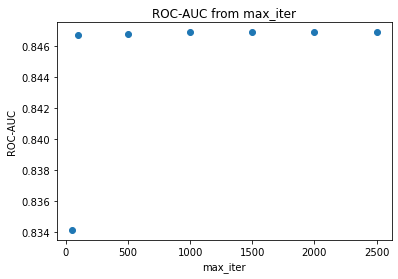

In [63]:
max_iter = [ 50, 100, 500, 1000, 1500, 2000, 2500]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
tol = [1e-5, 1e-3, 1e-4]
score_max_iter = []
for i in max_iter:
    model = linear_model.LogisticRegression(max_iter=i, solver='lbfgs', tol=1e-5)
    score_max_iter.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(max_iter, score_max_iter)
plt.xlabel('max_iter')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_iter')
plt.show()

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarn

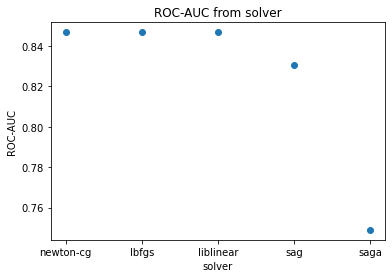

In [64]:
score_solver = []
for i in solver:
    model = linear_model.LogisticRegression(max_iter=500, solver=i, tol=1e-5)
    score_solver.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(solver, score_solver)
plt.xlabel('solver')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from solver')
plt.show()

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarn

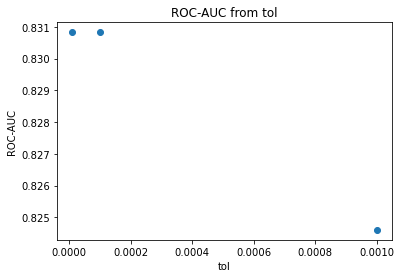

In [65]:
score_tol = []
for i in tol:
    model = linear_model.LogisticRegression(max_iter=500, solver='sag', tol=i)
    score_tol.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(tol, score_tol)
plt.xlabel('tol')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from tol')
plt.show()

Выбираем лучшую оценку и тестируем ее на тренировочных данных, вычисление AUC

In [66]:
model = linear_model.LogisticRegression(max_iter=500, tol=1e-05)
model.fit(X_train, Y_train)
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for logistic regression:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))


Auc score for logistic regression: 0.8449668986589713


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Предсказание на тестовых данных

In [67]:
res = model.predict_proba(test[features])

In [68]:
sample['stroke'] = res[:, 1]
sample.to_csv('submit_log_reg.csv', index = None )

### Random forrest классификатор

In [69]:
features = train.columns

In [70]:
res = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(train, res, test_size=0.2)

Поиск категорий с наибольшим влиянием. Категории малого влияния и с большой корреляцией будет удалены

In [71]:
model = RandomForestClassifier()
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

id 0.4904267883119481
gender 0.5120668942668987
age 0.8255045746021494
hypertension 0.5770243407772322
heart_disease 0.5877716799949427
ever_married 0.6236141573546685
work_type 0.6061693594132589
Residence_type 0.4906950241739619
avg_glucose_level 0.5024672803309336
bmi 0.6007244847447708
smoking_status 0.5671223906072396
stroke 1.0
work_type_is_children 0.5688202930383947
work_type_is_Private 0.5142532373183287
work_type_is_Never_worked 0.5019950913884875
work_type_is_Self-employed 0.5567483964453613
work_type_is_Govt_job 0.4925132453903183
smoking_status_target_enc 0.5671223906072396
smoking_status_is_no data 0.551196790466765
smoking_status_is_never smoked 0.5111988372943499
smoking_status_is_formerly smoked 0.5505434471763386
smoking_status_is_smokes 0.4734237303242649
residence_target_enc 0.4906950241739619
gender_target_enc 0.5120668942668987
gender_is_Male 0.5119567665468754
gender_is_Female 0.5117659672414089
gender_is_Other 0.5001907993054667


In [72]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'bmi', 'work_type_is_children',
            'work_type_is_Self-employed', 'smoking_status_target_enc', 'smoking_status_is_no data',
           'smoking_status_is_formerly smoked']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)
cor = X_train.corr()
cor.style.background_gradient(cmap='coolwarm')

,age,hypertension,heart_disease,ever_married,bmi,work_type_is_children,work_type_is_Self-employed,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_formerly smoked
age,1.000000,0.275104,0.254305,0.691305,0.350445,-0.638955,0.322412,0.368123,-0.370222,0.241103
hypertension,0.275104,1.000000,0.122339,0.178013,0.152533,-0.129027,0.107632,0.115564,-0.116999,0.074820
heart_disease,0.254305,0.122339,1.000000,0.127973,0.057448,-0.090220,0.106849,0.093654,-0.057007,0.083434
ever_married,0.691305,0.178013,0.127973,1.000000,0.339830,-0.544719,0.191028,0.297046,-0.320395,0.171776
bmi,0.350445,0.152533,0.057448,0.339830,1.000000,-0.452269,0.085798,0.232536,-0.271016,0.121999
work_type_is_children,-0.638955,-0.129027,-0.090220,-0.544719,-0.452269,1.000000,-0.173613,-0.397384,0.512795,-0.166673
work_type_is_Self-employed,0.322412,0.107632,0.106849,0.191028,0.085798,-0.173613,1.000000,0.109254,-0.094206,0.085591
smoking_status_target_enc,0.368123,0.115564,0.093654,0.297046,0.232536,-0.397384,0.109254,1.000000,-0.751880,0.840622
smoking_status_is_no data,-0.370222,-0.116999,-0.057007,-0.320395,-0.271016,0.512795,-0.094206,-0.751880,1.000000,-0.304021
smoking_status_is_formerly smoked,0.241103,0.074820,0.083434,0.171776,0.121999,-0.166673,0.085591,0.840622,-0.304021,1.000000


Удаляем информацию о браке, так как она сильно коррелирует с возрастом, а он важнее

Удаляем информацию о куривших раньше, по причине высокой корреляции с подверженных инсульту

In [73]:
features = ['age', 'hypertension', 'heart_disease', 'bmi', 'work_type_is_children',
            'work_type_is_Self-employed', 'smoking_status_target_enc', 'smoking_status_is_no data']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)

Поиск гиперпараметров для модели, возврат их и тестирование на тренировочных данных, прогназирование на тестовых данных

In [74]:
model = RandomForestClassifier()
parameters = {
    "n_estimators" :[10, 25, 50, 100, 150],
    "criterion" :['gini', 'entropy'],
    "max_depth" :[1, 3, 5, 7, 9, None],
    "min_samples_split" :[2, 4, 10, 20],
    "min_samples_leaf" :[1, 3, 5, 7],
    "max_features" :['auto', 'sqrt', 'log2', None]
    
        }
grid = GridSearchCV(model, parameters, n_jobs=14, scoring="roc_auc", cv=3, verbose=5)
grid.fit(X_train, Y_train)

Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   17.5s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:   29.5s
[Parallel(n_jobs=14)]: Done 260 tasks      | elapsed:   50.4s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 620 tasks      | elapsed:  1.4min
[Parallel(n_jobs=14)]: Done 854 tasks      | elapsed:  1.8min
[Parallel(n_jobs=14)]: Done 1124 tasks      | elapsed:  2.4min
[Parallel(n_jobs=14)]: Done 1430 tasks      | elapsed:  3.1min
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:  3.8min
[Parallel(n_jobs=14)]: Done 2150 tasks      | elapsed:  4.7min
[Parallel(n_jobs=14)]: Done 2564 tasks      | elapsed:  5.7min
[Parallel(n_jobs=14)]: Done 3014 tasks      | elapsed:  7.2min
[Parallel(n_jobs=14)]: Done 3500 tasks      | elapsed:  8.4min
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed:  9.8min
[Parallel(n_jobs=14)]: Done 4580 tasks      | e

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=14,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 10, 20],
                         'n_estimators': [10, 25, 50, 100, 150]},
             scoring='roc_auc', verbose=5)

In [72]:
grid.best_estimator_

RandomForestClassifier(max_depth=3, max_features='log2', min_samples_split=20,
                       n_estimators=50)

Построим графики AUC при изменение одного из параметров и фиксации остальных

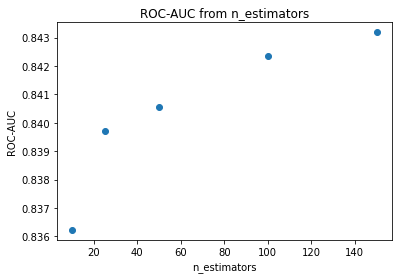

In [79]:
n_estimators = [10, 25, 50, 100, 150]
max_depth = [1, 3, 5, 7, 9, None]
max_features = ['auto', 'sqrt', 'log2']
score_n_estimators = []
for i in n_estimators:
    model = RandomForestClassifier(n_estimators=i, max_features='log2', max_depth=3)
    score_n_estimators.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(n_estimators, score_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from n_estimators')
plt.show()

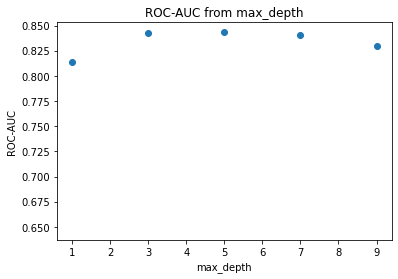

In [77]:
score_max_depth = []
for i in max_depth:
    model = RandomForestClassifier(n_estimators=50, max_features='log2', max_depth=i)
    score_max_depth.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(max_depth, score_max_depth)
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_depth')
plt.show()

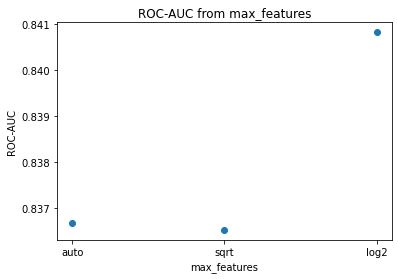

In [80]:
score_max_features = []
for i in max_features:
    model = RandomForestClassifier(n_estimators=50, max_features=i, max_depth=3)
    score_max_features.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(max_features, score_max_features)
plt.xlabel('max_features')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_features')
plt.show()

In [81]:
model = RandomForestClassifier(max_depth=3, max_features='log2', min_samples_split=20,
                       n_estimators=50)
model.fit(X_train, Y_train)
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for Random Forrest Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Random Forrest Classifier: 0.8167444202047324


In [82]:
res = model.predict_proba(test[features])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_ran_for.csv', index = None )

### DecisionTreeClassifier

In [83]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'bmi', 'work_type_is_children', 'work_type_is_Private', 'work_type_is_Never_worked',
            'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'gender_target_enc',  'gender_is_Male', 'gender_is_Female', 'gender_is_Other']

In [84]:
res = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(train, res, test_size=0.2)

In [85]:
model = DecisionTreeClassifier()
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

age 0.8339371687350356
hypertension 0.5846140969036739
heart_disease 0.5877495819318375
ever_married 0.623462414041924
Residence_type 0.5109198897925704
avg_glucose_level 0.4992366573440338
bmi 0.5994919680169983
work_type_is_children 0.5698642108492569
work_type_is_Private 0.48886890603346833
work_type_is_Never_worked 0.501950761638334
work_type_is_Self-employed 0.57015620816011
work_type_is_Govt_job 0.5059262161070877
smoking_status_target_enc 0.5980150755607152
smoking_status_is_no data 0.562581910812354
smoking_status_is_never smoked 0.5070506178283299
smoking_status_is_formerly smoked 0.5603774441706528
smoking_status_is_smokes 0.5092550844700312
gender_target_enc 0.5274772582200665
gender_is_Male 0.5273861521948137
gender_is_Female 0.5272165344719343
gender_is_Other 0.5001696177228794


In [86]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 
            'bmi', 'work_type_is_children', 'work_type_is_Private',
            'work_type_is_Self-employed', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_formerly smoked',
            'gender_target_enc',  'gender_is_Male', 'gender_is_Female']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)
cor = X_train.corr()
cor.style.background_gradient(cmap='coolwarm')

,age,hypertension,heart_disease,ever_married,bmi,work_type_is_children,work_type_is_Private,work_type_is_Self-employed,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_formerly smoked,gender_target_enc,gender_is_Male,gender_is_Female
age,1.000000,0.276690,0.251524,0.692229,0.352848,-0.640021,0.142717,0.323973,0.370903,-0.373103,0.242824,-0.032666,-0.033726,0.033756
hypertension,0.276690,1.000000,0.123720,0.180064,0.156933,-0.130375,0.000518,0.108566,0.119835,-0.118936,0.079940,0.024418,0.023863,-0.023669
heart_disease,0.251524,0.123720,1.000000,0.124844,0.057509,-0.089645,0.004005,0.091790,0.088800,-0.054352,0.078643,0.075710,0.076860,-0.076720
ever_married,0.692229,0.180064,0.124844,1.000000,0.343096,-0.544968,0.157114,0.197267,0.298186,-0.319868,0.173507,-0.035552,-0.037023,0.037107
bmi,0.352848,0.156933,0.057509,0.343096,1.000000,-0.456369,0.195497,0.088110,0.233772,-0.269880,0.125176,-0.024197,-0.023738,0.023561
work_type_is_children,-0.640021,-0.130375,-0.089645,-0.544968,-0.456369,1.000000,-0.471784,-0.174334,-0.400189,0.516704,-0.168191,0.097853,0.098898,-0.098647
work_type_is_Private,0.142717,0.000518,0.004005,0.157114,0.195497,-0.471784,1.000000,-0.497984,0.153971,-0.233143,0.035549,-0.055216,-0.055606,0.055432
work_type_is_Self-employed,0.323973,0.108566,0.091790,0.197267,0.088110,-0.174334,-0.497984,1.000000,0.108144,-0.096516,0.082005,-0.003086,-0.004747,0.005001
smoking_status_target_enc,0.370903,0.119835,0.088800,0.298186,0.233772,-0.400189,0.153971,0.108144,1.000000,-0.751710,0.841210,-0.000592,0.000259,-0.000398
smoking_status_is_no data,-0.373103,-0.118936,-0.054352,-0.319868,-0.269880,0.516704,-0.233143,-0.096516,-0.751710,1.000000,-0.304628,0.061957,0.063395,-0.063360


In [87]:
features = ['age', 'hypertension', 'heart_disease', 'bmi', 'work_type_is_Private','work_type_is_Self-employed', 
            'smoking_status_target_enc', 'smoking_status_is_no data',
            'gender_target_enc',  'gender_is_Male', 'gender_is_Female']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)

In [88]:
model = DecisionTreeClassifier()
parameters = {
    'splitter': ['best', 'random'],
    "criterion" :['gini', 'entropy'],
    "max_depth" :[1, 3, 5, 7, 9, None],
    "min_samples_split" :[2, 4, 10, 20],
    "min_samples_leaf" :[1, 3, 5, 7],
    "max_features" :['auto', 'sqrt', 'log2', None]
    
        }
grid = GridSearchCV(model, parameters, n_jobs=14, scoring="roc_auc", cv=5, verbose=5)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:    4.4s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:    5.7s
[Parallel(n_jobs=14)]: Done 260 tasks      | elapsed:    7.3s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   10.0s
[Parallel(n_jobs=14)]: Done 620 tasks      | elapsed:   13.2s
[Parallel(n_jobs=14)]: Done 854 tasks      | elapsed:   17.3s
[Parallel(n_jobs=14)]: Done 1124 tasks      | elapsed:   21.6s
[Parallel(n_jobs=14)]: Done 1430 tasks      | elapsed:   26.2s
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:   31.8s
[Parallel(n_jobs=14)]: Done 2150 tasks      | elapsed:   38.2s
[Parallel(n_jobs=14)]: Done 2564 tasks      | elapsed:   44.6s
[Parallel(n_jobs=14)]: Done 3014 tasks      | elapsed:   51.9s
[Parallel(n_jobs=14)]: Done 3500 tasks      | elapsed:   59.0s
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 4580 tasks      | e

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=14,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=5)

In [89]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3)

Построим графики AUC при изменение одного из параметров и фиксации остальных

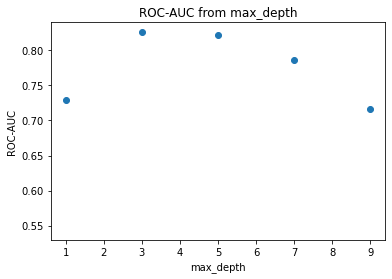

In [91]:
max_depth = [1, 3, 5, 7, 9, None]
min_samples_split = [2, 4, 10, 20]
min_samples_leaf = [1, 3, 5, 7]
score_max_depth = []
for i in max_depth:
    model = DecisionTreeClassifier(min_samples_leaf=1, min_samples_split=2, max_depth=i)
    score_max_depth.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(max_depth, score_max_depth)
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_depth')
plt.show()

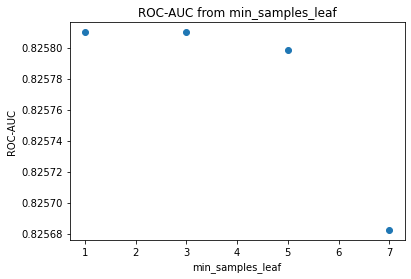

In [92]:
score_min_samples_leaf = []
for i in min_samples_leaf:
    model = DecisionTreeClassifier(min_samples_leaf=i, min_samples_split=2, max_depth=3)
    score_min_samples_leaf.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(min_samples_leaf, score_min_samples_leaf)
plt.xlabel('min_samples_leaf')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from min_samples_leaf')
plt.show()

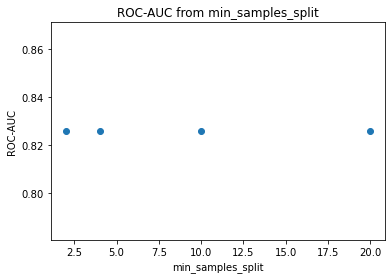

In [93]:
score_min_samples_split = []
for i in min_samples_split:
    model = DecisionTreeClassifier(min_samples_leaf=1, min_samples_split=i, max_depth=3)
    score_min_samples_split.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(min_samples_split, score_min_samples_split)
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from min_samples_split')
plt.show()

In [94]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(X_train, Y_train)
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for Decision Tree Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Decision Tree Classifier: 0.8425978871874394


In [95]:
res = model.predict_proba(test[features])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_des_tree.csv', index = None )

Заметка

Мы иследовали какие факторы влияют на возникнования инсульта, по статистике основными рисками:
гипертония;
холестерин крови;
диабет;
ожирение;
курение;
возраст;
болезни сердца;
стресс(брак, работа и все тягости нашей интересной и веселой жизни);

Для исследования я использовал 3 метода и они показали сие результаты:

Логистическая регрессия: возраст, гипертония, брак, сердечная болезнь, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму);


Random forest: возраст, гипертония, брак (исключен из списка возможностей, поскольку тишина сильно коррелирует с возрастом), bmi, heart_disease, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму);


Решающие деревья: возраст, гипертония, брак, сердечная болезнь, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму);

Как можно видеть, особенности, которые представляют риски для инсульта из медицинских знаний, также преобладают в используемых моделях, хотя интересно, что ИМТ не оказал влияния на логистическую регрессию. Важность статуса брака и типа работы может быть объяснена тем, что обе эти вещи вызывают стресс, и чем старше человек, тем больший риск инсульта представляет стресс.


Отсюда мы видим, что предсказано плюс минус одно и тоже, но с разной точностью.


Как видно лучшим оказался Логистическая регрессия, можно это обяснить тем что данные лучше ложаться на более простую модель.